In [12]:
!pip install pmdarima

ADF Statistic: 0.05323430091744131
p-value: 0.9627192743020793
Series is not stationary. Differencing required.
ADF Statistic: -6.356052516560467
p-value: 2.5412746700926768e-08
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[21] intercept   : AIC=inf, Time=14.30 sec
 ARIMA(0,0,0)(0,0,0)[21] intercept   : AIC=1881.052, Time=0.38 sec
 ARIMA(1,0,0)(1,0,0)[21] intercept   : AIC=1882.539, Time=3.26 sec
 ARIMA(0,0,1)(0,0,1)[21] intercept   : AIC=1882.398, Time=2.94 sec
 ARIMA(0,0,0)(0,0,0)[21]             : AIC=1879.417, Time=0.26 sec
 ARIMA(0,0,0)(1,0,0)[21] intercept   : AIC=1881.332, Time=1.26 sec
 ARIMA(0,0,0)(0,0,1)[21] intercept   : AIC=1881.276, Time=2.15 sec
 ARIMA(0,0,0)(1,0,1)[21] intercept   : AIC=1881.446, Time=4.93 sec
 ARIMA(1,0,0)(0,0,0)[21] intercept   : AIC=1882.579, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[21] intercept   : AIC=1882.537, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[21] intercept   : AIC=1879.980, Time=1.68 sec

Best model:  ARIMA(0,0,0)(0,0,0)[21]         

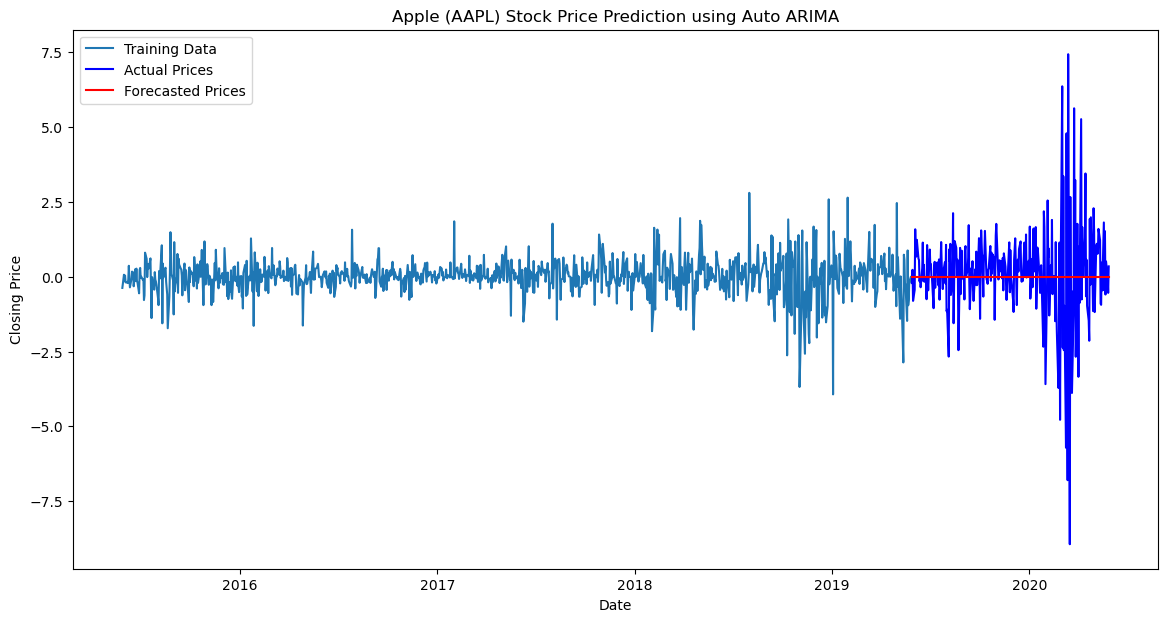

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv(r"C:\Users\Chandra Shekar\Downloads\AAPL.csv")

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data = data.asfreq('B')               # Sets Business Day frequency
data['Close'] = data['Close'].ffill()  # Forward fill missing values

closing_prices = data['Close']

def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

p_value = adf_test(closing_prices)
if p_value > 0.05:
    print("Series is not stationary. Differencing required.")
    closing_prices_diff = closing_prices.diff().dropna()
    adf_test(closing_prices_diff)
else:
    closing_prices_diff = closing_prices
    print("Series is stationary.")

train_size = int(len(closing_prices_diff) * 0.8)
train_data, test_data = closing_prices_diff[:train_size], closing_prices_diff[train_size:]

model = auto_arima(train_data, seasonal=True, m=21, stepwise=True, suppress_warnings=True, trace=True)

print(model.summary())

model_fit = model.fit(train_data)

forecast = model_fit.predict(n_periods=len(test_data))

mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Prices', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Prices', color='red')
plt.legend(loc='upper left')
plt.title('Apple (AAPL) Stock Price Prediction using Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[21] intercept   : AIC=3299.469, Time=24.99 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=3428.571, Time=0.52 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=3378.314, Time=1.68 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=3382.345, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=3428.625, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[21] intercept   : AIC=3296.534, Time=17.00 sec
 ARIMA(2,1,2)(0,0,0)[21] intercept   : AIC=3310.956, Time=6.34 sec
 ARIMA(2,1,2)(0,0,2)[21] intercept   : AIC=3295.978, Time=650.81 sec
 ARIMA(2,1,2)(1,0,2)[21] intercept   : AIC=3297.809, Time=270.47 sec
 ARIMA(1,1,2)(0,0,2)[21] intercept   : AIC=3387.732, Time=41.93 sec
 ARIMA(2,1,1)(0,0,2)[21] intercept   : AIC=3377.392, Time=132.43 sec
 ARIMA(3,1,2)(0,0,2)[21] intercept   : AIC=3351.235, Time=233.91 sec
 ARIMA(2,1,3)(0,0,2)[21] intercept   : AIC=3297.593, Time=275.58 sec
 ARIMA(1,1,1)(0,0,2)[21] intercept   : AIC=3380.755, Time=41.48 sec
 ARIM

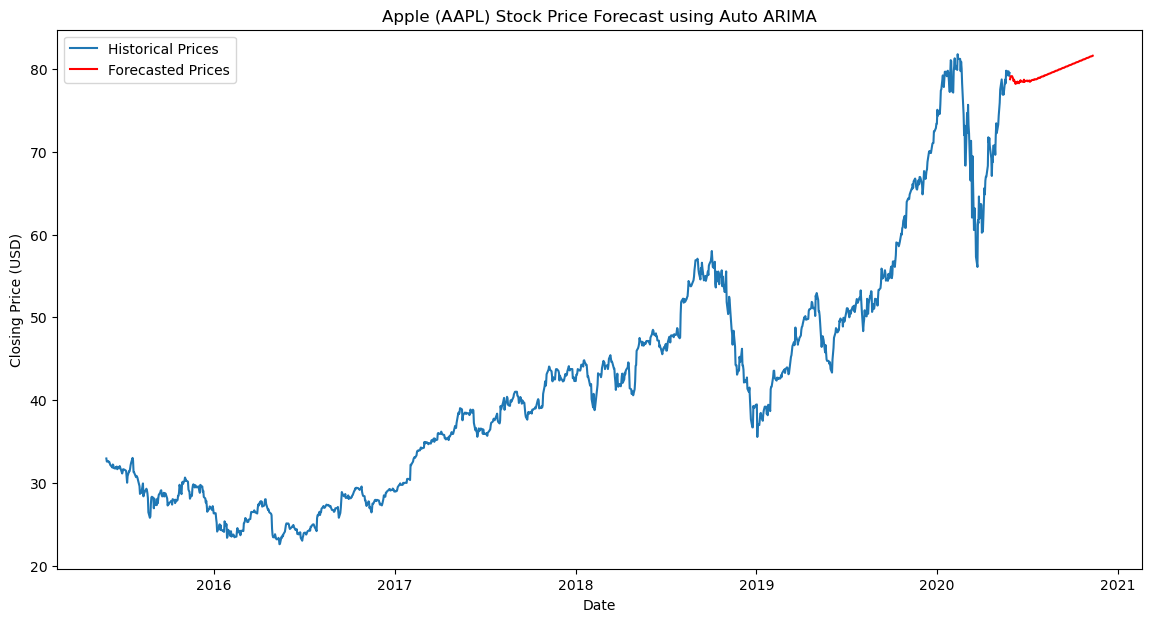

In [14]:
best_model = auto_arima(closing_prices, seasonal=True, m=21, stepwise=True, suppress_warnings=True, trace=True)

forecast_periods = 120
future_forecast = best_model.predict(n_periods=forecast_periods)

forecast_dates = pd.date_range(start=closing_prices.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_periods, freq='B')
plt.figure(figsize=(14, 7))
plt.plot(closing_prices, label='Historical Prices')

# Generate date range for forecast period
# Generate date range for forecast period (business days)
forecast_dates = pd.date_range(start=closing_prices.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

# Combine the last historical point with the forecast for continuity
extended_forecast = pd.Series(
    [closing_prices.iloc[-1]] + list(future_forecast),
    index=[closing_prices.index[-1]] + list(forecast_dates)
)


plt.plot(forecast_dates, future_forecast, label='Forecasted Prices', color='red')
plt.legend(loc='upper left')
plt.title('Apple (AAPL) Stock Price Forecast using Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()